<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL/tf2torch_mnist_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
# 현재 컴퓨터에서 CUDA(GPU Library)를 이용할 수 있는지 알아보기 위한 Flag
USE_CUDA = torch.cuda.is_available()
# USE_CUDA가 True일 경우, GPU를 할당 그 외엔 CPU 메모리 할당
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 30
learning_rate = 0.001 
batch_size = 100
print(DEVICE)

cuda


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

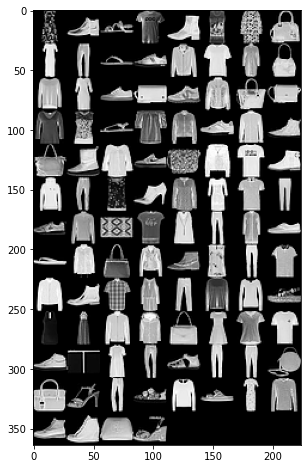

In [ ]:
img = torchvision.utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
class_names = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
class mnist_f_model(nn.Module):
  def __init__(self):
    super(mnist_f_model, self).__init__()

    self.linear1 = nn.Sequential(nn.Linear(28*28, 256), nn.ReLU(), nn.Linear(256, 128))
    self.linear2 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 10))

  def forward(self, x):
    x = x.view(-1, 28*28)
    out = self.linear1(x)
    out = self.linear2(out)

    return out

class mnist_conv_model(nn.Module):
  def __init__(self):
    super(mnist_conv_model, self).__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 3), nn.MaxPool2d(2), nn.ReLU())
    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3), nn.MaxPool2d(2), nn.ReLU())
    self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 2), nn.MaxPool2d(2), nn.ReLU())

    self.fc = nn.Sequential(nn.Linear(1024, 64), nn.ReLU(), nn.Linear(64, 10))

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)

    x = x.view(-1, 1024)
    out = self.fc(x)

    return out

In [ ]:
model = mnist_f_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated Total Size (MB): 0.93
----------------------------------------------------------------


In [ ]:
model2 = mnist_conv_model().to(DEVICE)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
from torchsummary import summary
summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7            [-1, 256, 4, 4]         131,328
         MaxPool2d-8            [-1, 256, 2, 2]               0
              ReLU-9            [-1, 256, 2, 2]               0
           Linear-10                   [-1, 64]          65,600
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 272,074
Trainable params: 272,074
Non-trainable params: 0
-------------------------------

In [ ]:
from tqdm.auto import tqdm

def train(model, train_loader, optimizer):
  
  model.train()

  for X_train, y_train in tqdm(train_loader):
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    
    # print(out.shape, y_train.shape)
    # 기울기를 계산하기 위해 zero_grad() 호출
    optimizer.zero_grad()

    out = model(X_train)
        
    loss = F.cross_entropy(out, y_train)
    
    # 기울기 계산
    loss.backward()
    optimizer.step()

  print(f'loss ={loss:.5f}')

def evaluate(model, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for X_test, y_test in tqdm(test_loader):
      X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
    
      out = model(X_test)
                      
      test_loss += F.cross_entropy(out, y_test, reduction='sum').item()
      
      pred = out.max(1, keepdim=True)[1]
      correct += pred.eq(y_test.view_as(pred)).sum().item()
  
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100.*correct/len(test_loader.dataset)
  
  return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer)

  test_loss, test_accuracy = evaluate(model, test_loader)
  print(f'Epoch: {epoch}, Test loss: {test_loss:.4f}, Test_accuracy: {test_accuracy:.2f}')

  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.06413


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Test loss: 0.4153, Test_accuracy: 88.72


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11400


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, Test loss: 0.4125, Test_accuracy: 88.98


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.06252


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, Test loss: 0.4217, Test_accuracy: 88.84


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.12188


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, Test loss: 0.3878, Test_accuracy: 89.37


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08389


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, Test loss: 0.4298, Test_accuracy: 88.88


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.18433


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, Test loss: 0.4171, Test_accuracy: 89.12


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.10663


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, Test loss: 0.4442, Test_accuracy: 89.13


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.18255


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, Test loss: 0.4414, Test_accuracy: 89.17


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.14004


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, Test loss: 0.4448, Test_accuracy: 88.93


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08875


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, Test loss: 0.4670, Test_accuracy: 88.49


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.13873


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11, Test loss: 0.4549, Test_accuracy: 89.58


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.12199


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, Test loss: 0.5049, Test_accuracy: 88.77


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.13699


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13, Test loss: 0.4805, Test_accuracy: 88.64


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08873


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14, Test loss: 0.5379, Test_accuracy: 88.78


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11217


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15, Test loss: 0.4727, Test_accuracy: 89.35


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08088


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16, Test loss: 0.5128, Test_accuracy: 89.00


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.17330


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17, Test loss: 0.5027, Test_accuracy: 88.63


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11189


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, Test loss: 0.4914, Test_accuracy: 88.78


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.15986


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, Test loss: 0.5131, Test_accuracy: 88.78


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11824


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, Test loss: 0.5144, Test_accuracy: 88.88


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08725


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21, Test loss: 0.5043, Test_accuracy: 89.41


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.04030


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22, Test loss: 0.5326, Test_accuracy: 89.18


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.24406


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23, Test loss: 0.5596, Test_accuracy: 89.00


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11782


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24, Test loss: 0.5839, Test_accuracy: 88.73


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11355


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25, Test loss: 0.5662, Test_accuracy: 88.54


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.04039


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26, Test loss: 0.5610, Test_accuracy: 89.07


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.06347


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, Test loss: 0.5399, Test_accuracy: 89.12


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11006


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28, Test loss: 0.5843, Test_accuracy: 89.43


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11484


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 29, Test loss: 0.5775, Test_accuracy: 89.32


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08544


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 30, Test loss: 0.6132, Test_accuracy: 88.84


In [ ]:
for epoch in range(1, EPOCHS+1):
  train(model2, train_loader, optimizer2)

  test_loss, test_accuracy = evaluate(model2, test_loader)
  print(f'Epoch: {epoch}, Test loss: {test_loss:.4f}, Test_accuracy: {test_accuracy:.2f}')

  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.37469


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Test loss: 0.4249, Test_accuracy: 84.24


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.25070


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, Test loss: 0.3286, Test_accuracy: 87.95


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.41112


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, Test loss: 0.3242, Test_accuracy: 88.36


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.30252


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, Test loss: 0.3021, Test_accuracy: 89.17


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.24502


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, Test loss: 0.2756, Test_accuracy: 90.12


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.25454


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, Test loss: 0.2688, Test_accuracy: 90.07


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.20786


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, Test loss: 0.2658, Test_accuracy: 90.37


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.14103


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, Test loss: 0.2652, Test_accuracy: 90.50


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.33487


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, Test loss: 0.2499, Test_accuracy: 90.98


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.10336


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, Test loss: 0.2502, Test_accuracy: 91.03


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.13345


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11, Test loss: 0.2538, Test_accuracy: 91.15


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.24973


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, Test loss: 0.2616, Test_accuracy: 91.40


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.15356


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13, Test loss: 0.2734, Test_accuracy: 90.99


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.23540


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14, Test loss: 0.2829, Test_accuracy: 91.32


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11041


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15, Test loss: 0.2880, Test_accuracy: 91.27


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.13791


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16, Test loss: 0.2943, Test_accuracy: 91.30


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.05735


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17, Test loss: 0.3199, Test_accuracy: 91.12


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.05294


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, Test loss: 0.3293, Test_accuracy: 91.33


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.11888


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, Test loss: 0.3359, Test_accuracy: 90.93


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.07412


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, Test loss: 0.3644, Test_accuracy: 91.28


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.06935


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21, Test loss: 0.3660, Test_accuracy: 91.29


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.12777


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22, Test loss: 0.3892, Test_accuracy: 90.94


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.00299


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23, Test loss: 0.4150, Test_accuracy: 90.89


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.08831


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24, Test loss: 0.4277, Test_accuracy: 91.06


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.09621


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25, Test loss: 0.4232, Test_accuracy: 90.89


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.05897


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26, Test loss: 0.4470, Test_accuracy: 90.90


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.02908


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, Test loss: 0.4537, Test_accuracy: 91.16


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.03417


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28, Test loss: 0.4542, Test_accuracy: 91.26


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.03723


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 29, Test loss: 0.4959, Test_accuracy: 90.85


  0%|          | 0/600 [00:00<?, ?it/s]

loss =0.06261


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 30, Test loss: 0.5211, Test_accuracy: 90.92
